### Описание

Вторая попятка написать  программу для автоматической выборки **хороших** наблюдений.
В основе данной программы будет лежать модуль scipy и имеющиеся в нем статистические модели.

Условия выборки хороших наблюдений:

+ Максимальная точка массива среднего профиля лежит в пределах границ среднего профиля, границы которого определяются посредством крорреляции с шаблоном.

+ Тест Шапиро-Уилка должен подтверждать нормальность распределения значений шумовой дорожки.

+ Максимальная точка в данных должна в 3.5(возможно 4) раза превышать СКО для шумовой дорожки. 

+ Минимальная точка в данных **не** должна в 3.5(возможно 4.5) раза превышать СКО для шумовой дорожки.

In [ ]:
reset

In [9]:
import os
import sys
import glob
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from astropy.time import Time
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
import scipy as sp
'''
for style in plt.style.available[:4]:
    plt.style.use(style)
'''
plt.style.use('dark_background')

In [13]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = None
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "E:\\Disk.Yandex\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"

elif 'Linux' in platform.platform() and '4.1.18' in platform.release():
    _ = '/storage/9C33-6BBD/'
    DATA_DIR = None
    PATTERN_DIR = _ + 'git_projects/pattern_profiles/'
    PACK_DIR = _ + 'git_projects/PRAO_module/'
    DELIMITER = '/'
else:
    print('unknown system', platform.platform(), platform.release())
    

sys.path.append(PACK_DIR)
from PRAO import *

In [5]:
files = sorted(glob.glob('all_data/*profiles.txt'))

In [6]:
header, main_profile, data_pulses, back = read_profiles(files[51])

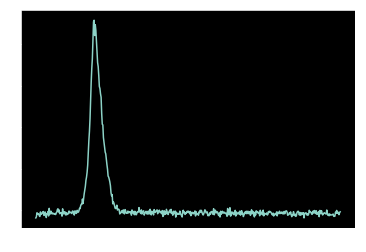

In [21]:
%matplotlib inline
plt.close()
plt.plot(np.roll(main_profile, 100 - np.argmax(main_profile)))
plt.show()

In [14]:
pattern = np.loadtxt(PATTERN_DIR + DELIMITER + header['name'] + '_' +
                     header['tay'] + '.csv',  skiprows=4) 
l_edge, r_edge = edgesOprofile(main_profile, pattern)
noise = np.append(main_profile[:l_edge], main_profile[r_edge:])

### Попытка фитирования шума

In [15]:
fp, residuals, rank, sv, rcond = np.polyfit(range(len(noise)), noise, 1, full=True)

In [16]:
f = np.poly1d(fp)

In [17]:
print(f)

 
4.867e-05 x - 0.1407


In [19]:
print(residuals)

[3.25672217]


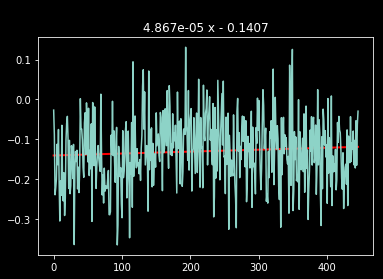

In [20]:
fx = range(len(noise))
plt.close()
plt.title(f)
plt.plot(fx, f(fx), linewidth=2, color='r')
plt.plot(noise)
plt.show()

In [90]:
stats.shapiro(noise)

(0.9928853511810303, 0.6332384347915649)

060313_1237+25_00_profiles.txt
080313_1237+25_00_profiles.txt
140113_1112+50_00_profiles.txt
160915_1133+16_00_profiles.txt
260417_0950+08_00_profiles.txt
290517_0950+08_00_profiles.txt


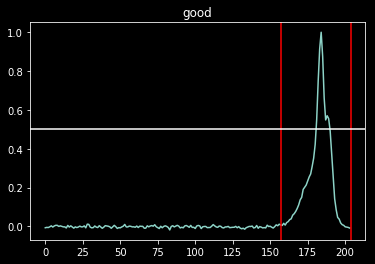

In [38]:
for idx, file in enumerate(files):
    try:
        header, main_profile, data_pulses, back = read_profiles(file)
        
        main_profile -= np.median(main_profile)
        #main_profile = np.roll(main_profile, int(int(header['numpointwin'])/2) - np.argmax(main_profile))
        main_profile /= np.max(main_profile)
        
        pattern = np.loadtxt(PATTERN_DIR + DELIMITER + header['name'] + '_' +
                         header['tay'] + '.csv',  skiprows=4) a
        l_edge, r_edge = edgesOprofile(main_profile, pattern)
        noise = np.append(main_profile[:l_edge], main_profile[r_edge:])
        
        intersection = np.argwhere(np.diff(np.sign(main_profile - 0.5*np.max(main_profile)))).flatten()
        pulses = str(len(intersection)/2)
        
        fp, residuals, rank, sv, rcond = np.polyfit(range(len(noise)), noise, 1, full=True)
        f = np.poly1d(fp)
        
        cond_1 = float(pulses) <=10
        cond_2 = abs(round(np.median(noise) - np.mean(noise), 4)) <= 0.0055
        cond_3 = round(SNR(main_profile, l_edge, r_edge), 1) >= 3.5
        cond_4 = abs(round(f[0], 5)) < 0.05
        
        
        
        plt.close()
        
        if cond_1 and cond_2 and cond_3 and cond_4:
            plt.title('good')
        else:
            plt.title('bad')
            
        plt.plot(main_profile)
        plt.axvline(l_edge, color='r')
        plt.axvline(r_edge, color='r')
        plt.axhline(0.5*np.max(main_profile))
        plt.savefig('./plot_stat_shapiro/' + str(idx) + '.png', format='png', dpi=150)
    except OSError:
        print(file)
    except ValueError:
        print(file)

In [63]:
pulsar_name = '1112+50'
global_dir_pulsar = ALL_DATA + pulsar_name + os.sep

In [64]:
global_dir_pulsar

'F:\\YandexDisk\\1.Работа\\Результаты обработки\\1112+50\\'

In [65]:
global_files = sorted(glob.glob(global_dir_pulsar + '20*' + os.sep + '*' + os.sep + '*_profiles.txt'))

In [66]:
len(global_files)

2070

In [67]:
def quality_data(profile, l_edge, r_edge):
    """
    Function for checking average profile for qood or bad data. 
    Input: average profile, left edge, rigtht edge
    Output: True if average profile is good or False if bad 
    
    """
       
    profile -= np.median(profile)
    #main_profile = np.roll(main_profile, int(int(header['numpointwin'])/2) - np.argmax(main_profile))
    profile /= np.max(profile)
    
    noise = np.append(profile[:l_edge], profile[r_edge:])
        
    intersection = np.argwhere(np.diff(np.sign(profile - 0.5*np.max(profile)))).flatten()
    pulses = str(len(intersection)/2)
        
    fp, residuals, rank, sv, rcond = np.polyfit(range(len(noise)), noise, 1, full=True)
    f = np.poly1d(fp)
        
    cond_1 = float(pulses) <=10
    cond_2 = abs(round(np.median(noise) - np.mean(noise), 4)) <= 0.0055
    cond_3 = round(SNR(profile, l_edge, r_edge), 1) >= 3.5
    cond_4 = abs(round(f[0], 5)) < 0.05
        
    if cond_1 and cond_2 and cond_3 and cond_4:
        return True
    else:
        return False

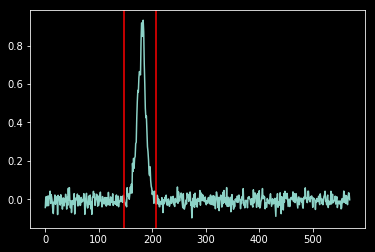

In [73]:
for file in tqdm_notebook(global_files[2016:]):
    try:
        header, main_profile, data_pulses, back = read_profiles(file)
        pattern = np.loadtxt(
            PATTERN_DIR
            + DELIMITER
            + header['name']
            + '_'
            + header['tay']
            + '.csv',  skiprows=4)
        
        l_edge, r_edge = edgesOprofile(main_profile, pattern)
        
        plt.close()
        plt.plot(main_profile)
        plt.axvline(l_edge, color='r')
        plt.axvline(r_edge, color='r')
        
        if gb_data(main_profile, l_edge, r_edge):
            plt.savefig(
                './global_test_pic/yes/'
                + os.path.basename(file)[:-4]
                + '.png', format='png')
        else:
            plt.savefig(
                './global_test_pic/no/'
                + os.path.basename(file)[:-4]
                + '.png', format='png')
            
    except ValueError:
        with open('valerr.log', 'a') as f:
            f.write(os.path.basename(file))
            f.write('\n')
    except OSError:
        with open('oserr.log', 'a') as f:
            f.write(os.path.basename(file))
            f.write('\n')

In [57]:
os.path.basename(global_files[0][:-4])

'200112_1237+25_00_profiles'